## 均值回归
移动平均线（MA）：计算一定周期内的价格均值，当当前价格远高于或低于移动平均值时，视为超买或超卖信号。

Z-Score指标：通过计算价格与其历史均值的标准差倍数，判断当前价格是否处于极端状态。例如，当 Z-Score 超过某个阈值（如 +2 或 -2）时，可以视为超买或超卖状态，从而触发买入或卖出的信号。

In [1]:
import sys
sys.path.append("..")
from BacktestApp import BacktestApp
from utils import vwap, is_within_specific_minutes_of_close
from PositionManagerPlus import PositionManager

import pandas as pd
import numpy as np

class Trend:
    def __init__(self, contract, pm:PositionManager):
        self.contract = contract
        self.pm = pm
        
    def calculate_open_amount(self, bars):
        if self.pm.net_liquidation is None or self.pm.available_funds is None:
            print("PositionManager.calculate_open_amount net_liquidation or available_funds is None")
            return 0
        
        target_market_value = self.pm.net_liquidation * 0.5
        if target_market_value > self.pm.available_funds: return 0
        
        open_amount = target_market_value / bars.iloc[-1]['close']
        open_amount = round(open_amount / 10) * 10  # 调整为 10 的倍数
        return int(open_amount)

    def find_position(self):
        is_match = lambda item: (
            item["contract"] == self.contract and
            item["strategy"] == "Trend"
        )
        return self.pm.find_position(is_match)
    
    def setParams(self, bars, period=20):
        bars['MA'] = bars['close'].ewm(span=period, adjust=False).mean()
        bars['std'] = bars['close'].rolling(window=period).std()
        bars['z_score'] = (bars['close'] - bars['MA']) / bars['std']
        bars['amp'] = (bars['close'] - bars['MA']) / bars['close']

        return bars

    def get_open_signal(self, bars, z_score=3):
        row = bars.iloc[-1]
        z_score_ins = row["z_score"]
        amp = row["amp"]
        if z_score_ins > z_score and abs(amp) > 0.005:
            return -1
        if z_score_ins < -1 * z_score and abs(amp) > 0.005:
            return 1
        
    def get_close_signal(self, bars, z_score=2):
        z_score_ins = bars.iloc[-1]["z_score"]
        return abs(z_score_ins) < z_score
    
    def update(self, bars):
        # 开仓信号
        position = self.find_position()
        if not position:
            signal = self.get_open_signal(bars, z_score=3)
            if signal and not is_within_specific_minutes_of_close(bars, 60):
                amount = self.calculate_open_amount(bars) * signal
                self.pm.open_position(self.contract, "Trend", amount, bars)
        
        position = self.find_position()
        if position:
            # signal = self.get_close_signal(bars)
            # if signal:
            #     self.pm.close_position(position, bars, reason="平仓信号出现")
            #     return
            if (bars.iloc[-1]["date"] - position["date"]) >= pd.Timedelta(minutes=60):
                self.pm.close_position(position, bars, reason="时间到期")
                return
                    
class TrendBacktestApp(BacktestApp):
    def __init__(self, config_file="config.yml", **kwargs):
        super().__init__(config_file, **kwargs)
        self.trend = { contract.symbol: Trend(contract, self.pm) for contract in self.contracts }
        
    def on_bar_update(self, contract, bars, has_new_bar):
        bars = bars.copy()
        self.trend[contract.symbol].update(bars)

def prepare_data(bars):
    trend = Trend(None, None)
    return trend.setParams(bars)

try:
    ba = TrendBacktestApp(config_file="../config_backtest.yml", clientId=20, debug=True, autoConnect=False)
    end_date = "2025-03-31"
    duration_str = "200 D"
    ba.minutes_backtest(end_date, duration_str, pre_process_bar_callback=prepare_data)
finally:
    if ba.ib: pass
        # ba.ib.disconnect()

【2024-06-21 12:30:00-04:00】【Trend】开仓: AAPL, 价格: 210.02, 数量：2380，浮动盈亏：None, 原因：None
【2024-06-21 13:30:00-04:00】【Trend】平仓: AAPL, 价格: 210.08, 数量：-2380，浮动盈亏：142.8000000000054, 原因：时间到期
【2024-08-05 14:40:00-04:00】【Trend】开仓: AAPL, 价格: 208.69, 数量：2400，浮动盈亏：None, 原因：None
【2024-08-05 15:40:00-04:00】【Trend】平仓: AAPL, 价格: 208.18, 数量：-2400，浮动盈亏：-1223.9999999999782, 原因：时间到期
【2024-09-18 14:00:00-04:00】【Trend】开仓: AAPL, 价格: 222.26, 数量：-2250，浮动盈亏：None, 原因：None
【2024-09-18 15:00:00-04:00】【Trend】平仓: AAPL, 价格: 219.78, 数量：2250，浮动盈亏：5579.999999999977, 原因：时间到期
【2024-10-23 11:53:00-04:00】【Trend】开仓: AAPL, 价格: 232.24, 数量：2140，浮动盈亏：None, 原因：None
【2024-10-23 12:53:00-04:00】【Trend】平仓: AAPL, 价格: 229.13, 数量：-2140，浮动盈亏：-6655.400000000029, 原因：时间到期
【2025-02-13 11:06:00-05:00】【Trend】开仓: AAPL, 价格: 240.88, 数量：-2070，浮动盈亏：None, 原因：None
【2025-02-13 12:06:00-05:00】【Trend】平仓: AAPL, 价格: 240.73, 数量：2070，浮动盈亏：310.50000000001177, 原因：时间到期
【2025-03-05 10:21:00-05:00】【Trend】开仓: AAPL, 价格: 230.74, 数量：2160，浮动盈亏：None, 原因：None
【2025-03-05 1

In [2]:
from PlotPlus import PlotPlus
idx = 0
daily = ba.get_historical_data(ba.contracts[0], end_date, duration_str, '1 day')

7 2024-06-21


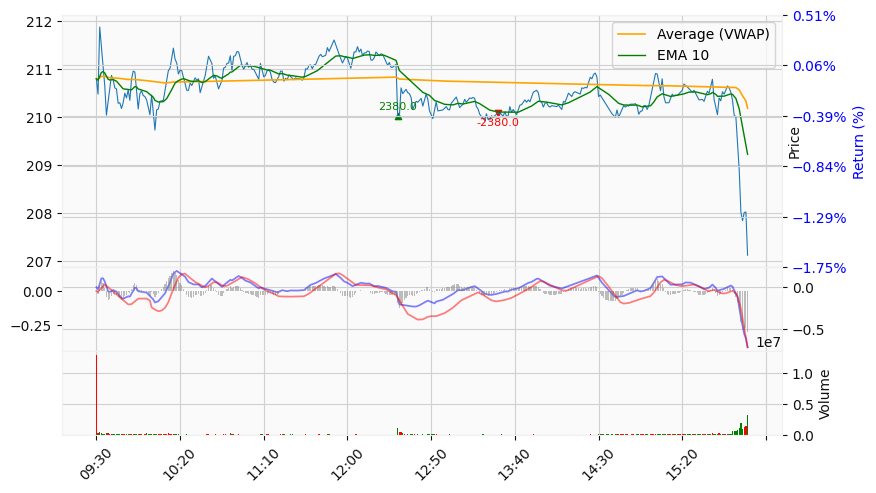

In [3]:
while True:
    date = daily.iloc[idx]['date']
    trade_log = pd.DataFrame(ba.pm.trade_log)
    has_trade = not trade_log[trade_log['date'].dt.date == date].empty
    idx += 1
    if has_trade:
        print(idx, date)
        df = ba.get_historical_data(ba.contracts[0], date)
        pp = PlotPlus(df, ema_window=20)
        pp.plot_basic(style_type="line")
        pp.mark_bs_point(ba.pm.trade_log)
        pp.show()
        break

In [4]:
# 按照pnl从大到小排序
pd.DataFrame(ba.pm.trade_log).sort_values(by='pnl', ascending=False).reset_index(drop=True)

,date,symbol,strategy,open_or_close,direction,price,amount,commission,pnl,reason
0,2024-09-18 15:00:00-04:00,AAPL,Trend,平仓,BUY,219.78,2250,39.560400,5580.0,时间到期
1,2025-02-13 12:06:00-05:00,AAPL,Trend,平仓,BUY,240.73,2070,39.864888,310.5,时间到期
2,2025-03-05 11:21:00-05:00,AAPL,Trend,平仓,SELL,230.84,-2160,39.889152,216.0,时间到期
3,2024-06-21 13:30:00-04:00,AAPL,Trend,平仓,SELL,210.08,-2380,39.999232,142.8,时间到期
4,2024-08-05 15:40:00-04:00,AAPL,Trend,平仓,SELL,208.18,-2400,39.970560,-1224.0,时间到期
5,2024-10-23 12:53:00-04:00,AAPL,Trend,平仓,SELL,229.13,-2140,39.227056,-6655.4,时间到期
6,2024-06-21 12:30:00-04:00,AAPL,Trend,开仓,BUY,210.02,2380,39.987808,NaN,None
7,2024-08-05 14:40:00-04:00,AAPL,Trend,开仓,BUY,208.69,2400,40.068480,NaN,None
8,2024-09-18 14:00:00-04:00,AAPL,Trend,开仓,SELL,222.26,-2250,40.006800,NaN,None
9,2024-10-23 11:53:00-04:00,AAPL,Trend,开仓,BUY,232.24,2140,39.759488,NaN,None


In [5]:
ba.statistic()

{'cumulative_pnl': np.float64(-2068.3063119999133),
 'max_drawdown': np.float64(0.006963329156865657),
 'sharpe_ratio': np.float64(-4.517833976240382),
 'volatility': np.float64(0.008319779983124892),
 'daily_return': np.float64(-1.0267399534151867e-05),
 'commission': np.float64(478.09546400000005)}

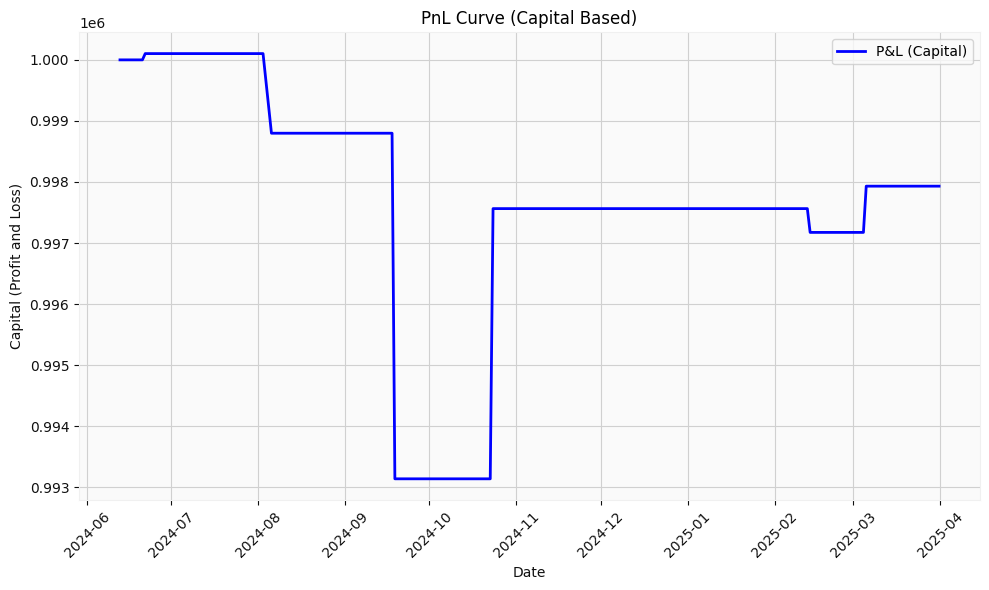

In [6]:
ba.plot_pnl()